# Reproduction of YOLO Object Detection 

This notebook is based on the assignment in Andrew Ng's [course on object detection](https://www.coursera.org/learn/convolutional-neural-networks). However, I apply here Tensorflow 2.x and add the YOLOv2 with pretrained weights using the [conversion](https://github.com/allanzelener/YAD2K) script by Allan Zelender. I also do some minor changes to the code, e.g.  to deal with images with different size.

The model is trained on the [COCO dataset](http://cocodataset.org/#home) to recognize 80 objects. So if not newly (partialy)-trained, the system will be also able to detect and recognize only this classes.

# Imports

In [6]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import imageio
import numpy as np
import pandas as pd
# import PIL

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D
from tensorflow.keras.models import load_model, Model

# Comes from Coursera (Could be found online - I wouldnt provide it due to legal consideration)
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
# Allan Zelender's work
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

# Creating the Model

The following steps need to be done:
* Convert the original Darknet implementation into Tensorflow with the pretrained weights
* Process the output of the model in order to select the right bounding boxes
* Perform Nonmax surpression and selection over a minimum confidence level
* Wrapping  the functions


## Converting YOLOv2 into Tensorflow

First al all, we need to clone the project [YAD2K](https://github.com/allanzelener/YAD2K) 

We need to install wget (since not preinstalled on Windows) and than follow the installation instructions.

Second, we need to download the config file and the weights for the [YOLOv2 608x608](https://pjreddie.com/darknet/yolo/) from the darknet. They need to bee placed at the rood (the 'yad2k' folder).

Third, we need to run in anaconda prompt the following comands:

```bash
wget http://pjreddie.com/media/files/yolov2.weights
wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2.cfg
python yad2k.py yolo.cfg yolo.weights model_data/yolo.h5
python test_yolo.py model_data/yolo.h5  # output in images/out/
```
**Note**: this worked for me - I replaced th ./ with **python**. I also replaced the last part of the strings the yolo with **yolov2**

In [2]:
# So now we can import the model
# Choose ofcourse the path where you have placed the h5
yolo_model = load_model("../yad2k/model_data/yolo.h5")
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [5]:
yolo_model.output_shape

(None, 19, 19, 425)

## Convert output of the model to usable bounding box tensors

The output of yolo_model is a (m, 19, 19, 425) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you.

The project of Allan Zelender provides a function that does this. It requires also (the length) of a list with the class names (included in his project) and ancors size in the form of a dict (provided by Andrew Ng)

In [26]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

In [9]:
# That is the confersion function
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
yolo_outputs

(<tf.Tensor 'Sigmoid_2:0' shape=(None, None, None, 5, 1) dtype=float32>,
 <tf.Tensor 'truediv_2:0' shape=(None, None, None, 5, 2) dtype=float32>,
 <tf.Tensor 'truediv_3:0' shape=(None, None, None, 5, 2) dtype=float32>,
 <tf.Tensor 'Softmax_1:0' shape=(None, None, None, 5, 80) dtype=float32>)

## Filtering the boxes
The output are all 5 ancor boxes for all 19x19 grid cells. We need to filter them out 

* First filtering over a certain confidence level
* Second, filtering with non-max suppression (IoU)

In [11]:
# First filtering over a certain confidence level
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = tf.argmax(box_scores, axis=-1) #K.argmax(box_scores, axis = -1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    
#     # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
#     # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
#     # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(tensor = box_class_scores, mask = filtering_mask)
    boxes = tf.boolean_mask(tensor = boxes, mask = filtering_mask)
    classes = tf.boolean_mask(tensor = box_classes, mask = filtering_mask)
    
    return scores, boxes, classes

In [13]:
# Second, filtering with non-max suppression (IoU)
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(
                    boxes=boxes,
                    scores=scores,
                    max_output_size=max_boxes_tensor,
                    iou_threshold=iou_threshold,
                    name=None
                    )
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    
    return scores, boxes, classes

In [57]:
# Wrapper Function

def yolo_eval(yolo_outputs, image, max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Get the size of the image to have it reshape later
    image_shape = (float(image.size[1]), float(image.size[0]))
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # 
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=max_boxes, iou_threshold=iou_threshold)
    
    return scores, boxes, classes

# Prediction

**The predict function:**
This function uses the functions defined previously to make preditions on new images and also such given by Andrew Ng

In [58]:
def predict(image_file):
    
    # Preprocess the image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    # Get the output of the YOLO
    output = yolo_model(image_data)
    # Transform the YOLO outputs to the shape needed for the evaluation of the output
    yolo_outputs = yolo_head(output, anchors, len(class_names))
    # Get the Boxes, their Cordinates and the coresponding Classes after
    # Confidence Filtering and Non-max-surpression and 
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, image)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # # Display the results in the notebook
    # plt.figure(figsize = (20,10))
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image, aspect=1)
    
    return out_scores, out_boxes, out_classes, image

Found 6 boxes for street.jpg
car 0.63 (589, 547) (753, 671)
person 0.76 (505, 523) (666, 861)
person 0.78 (904, 486) (1151, 1015)
person 0.79 (60, 550) (263, 923)
bicycle 0.79 (764, 710) (1241, 1040)
car 0.82 (649, 587) (985, 767)


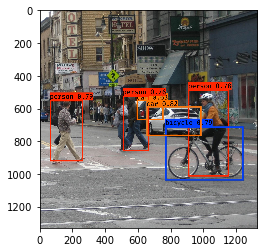

In [62]:
out_scores, out_boxes, out_classes, image = predict("street.jpg")

# Next Step

* Extend to deal with video files
* Train on custom data
* Populate with Tensorflow Servise